In [2]:
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
import matplotlib.pyplot as plt
import pandas as pd
from typing import List
from typing import Optional
from typing import Tuple
import seaborn as sns
import numpy as np
sns.set_theme(rc={'figure.figsize':(12.7,8.27)})

pygame 2.5.2 (SDL 2.28.2, Python 3.8.19)
Hello from the pygame community. https://www.pygame.org/contribute.html


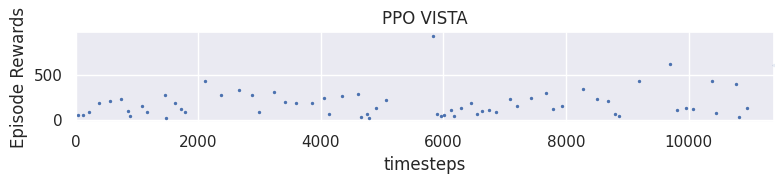

In [72]:
log_dir47 = "/mnt/persistent/collision-avoidance-a2c/tmp_2/"
timesteps = 500_000
plot_results([
    log_dir47
], timesteps, results_plotter.X_TIMESTEPS, "PPO VISTA")
plt.show()

<Axes: xlabel='index', ylabel='course_completion_rate'>

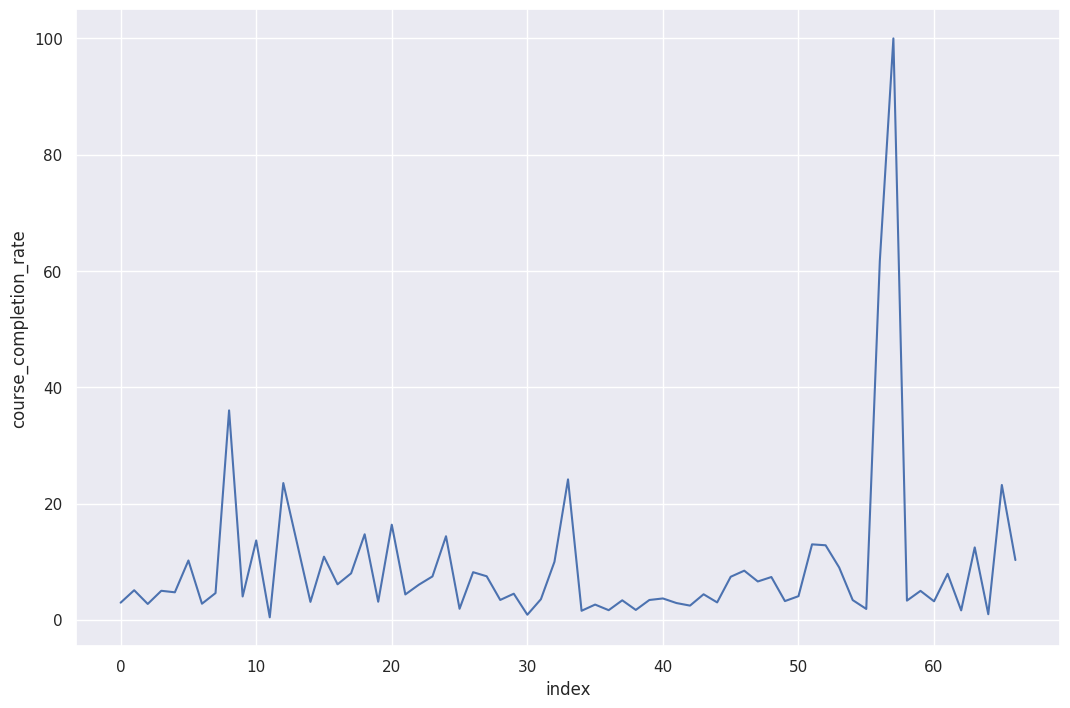

In [73]:
df47 = pd.read_csv(log_dir47 + "/monitor.csv", header=1).reset_index()
sns.lineplot(df47, x="index", y="course_completion_rate")

<Axes: xlabel='index', ylabel='course_completion_rate'>

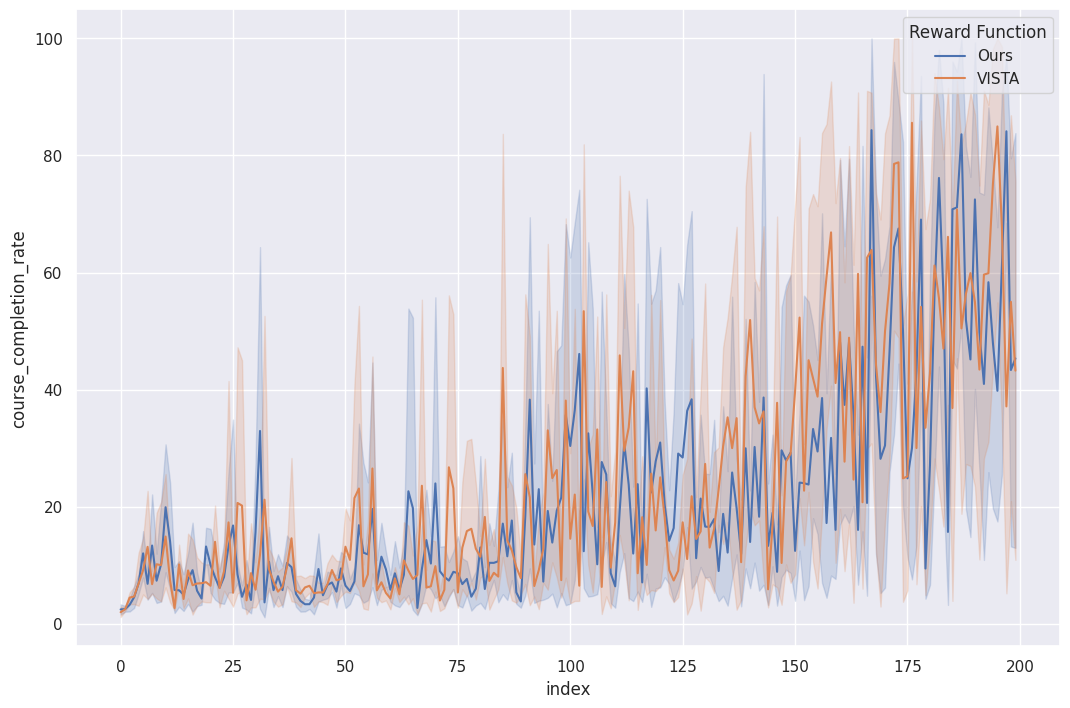

In [653]:
old_log_dir1 = "/mnt/persistent/lane-follow-ppo-vista-reward/tmp_1/"
old_log_dir2 = "/mnt/persistent/lane-follow-ppo-vista-reward/tmp_2/"
old_log_dir3 = "/mnt/persistent/lane-follow-ppo-vista-reward/tmp_3/"
old_log_dir4 = "/mnt/persistent/lane-follow-ppo-vista-reward/tmp_4/"
old_log_dir5 = "/mnt/persistent/lane-follow-ppo-vista-reward/tmp_5/"
old_log_dir8 = "/mnt/persistent/lane-follow-ppo-vista-reward/tmp_8/"

log_dir1 = "/mnt/persistent/lane-follow-ppo-my-reward/tmp_1/"
log_dir2 = "/mnt/persistent/lane-follow-ppo-my-reward/tmp_2/"
log_dir3 = "/mnt/persistent/lane-follow-ppo-my-reward/tmp_3/"
log_dir4 = "/mnt/persistent/lane-follow-ppo-my-reward/tmp_4/"
log_dir5 = "/mnt/persistent/lane-follow-ppo-my-reward/tmp_5/"
log_dir8 = "/mnt/persistent/lane-follow-ppo-my-reward/tmp_8/"


my_df1 = pd.read_csv(log_dir1 + "/monitor.csv", header=1).reset_index()
my_df2 = pd.read_csv(log_dir2 + "/monitor.csv", header=1).reset_index()
my_df3 = pd.read_csv(log_dir3 + "/monitor.csv", header=1).reset_index()
my_df4 = pd.read_csv(log_dir4 + "/monitor.csv", header=1).reset_index()
my_df5 = pd.read_csv(log_dir5 + "/monitor.csv", header=1).reset_index()
my_df8 = pd.read_csv(log_dir8 + "/monitor.csv", header=1).reset_index()
my_df = pd.concat([
    my_df1,
    my_df2,
    my_df3,
    my_df4,
    my_df5,
    my_df8,
])
my_df["Reward Function"] = "Ours"

vista_df1 = pd.read_csv(old_log_dir1 + "/monitor.csv", header=1).reset_index()
vista_df2 = pd.read_csv(old_log_dir2 + "/monitor.csv", header=1).reset_index()
vista_df3 = pd.read_csv(old_log_dir3 + "/monitor.csv", header=1).reset_index()
vista_df4 = pd.read_csv(old_log_dir4 + "/monitor.csv", header=1).reset_index()
vista_df5 = pd.read_csv(old_log_dir5 + "/monitor.csv", header=1).reset_index()
vista_df8 = pd.read_csv(old_log_dir8 + "/monitor.csv", header=1).reset_index()
vista_df = pd.concat([
    vista_df1,
    vista_df2,
    vista_df3,
    vista_df4,
    vista_df5,
    vista_df8,
])
vista_df["Reward Function"] = "VISTA"

df = pd.concat([my_df, vista_df])
sns.lineplot(df, x="index", y="course_completion_rate",hue="Reward Function")

In [114]:
df9 = pd.read_csv(log_dir9 + "/monitor.csv", header=1).reset_index()
df9['Algorithm'] = 'PPO'
df10 = pd.read_csv(log_dir10 + "/monitor.csv", header=1).reset_index()
df10['Algorithm'] = 'PPO'
df11 = pd.read_csv(log_dir11 + "/monitor.csv", header=1).reset_index()
df11['Algorithm'] = 'PPO'
df12 = pd.read_csv(log_dir12 + "/monitor.csv", header=1).reset_index()
df12['Algorithm'] = 'PPO'
df_concat = pd.concat([df9, df10, df11, df12])
df_concat = df_concat.rename(columns={'index': 'Episode', 'course_completion_rate': 'Course Completion Rate'})
df_concat['NN'] =  '256 units'

In [117]:
df30 = pd.read_csv(log_dir30 + "/monitor.csv", header=1).reset_index()
df30['Algorithm'] = 'PPO'

df31 = pd.read_csv(log_dir31 + "/monitor.csv", header=1).reset_index()
df31['Algorithm'] = 'PPO'
q = df31["course_completion_rate"].quantile(0.99)
df31 = df31[df31["course_completion_rate"] < q]

df32 = pd.read_csv(log_dir32 + "/monitor.csv", header=1).reset_index()
df32['Algorithm'] = 'PPO'
q = df32["course_completion_rate"].quantile(0.99)
df32 = df32[df32["course_completion_rate"] < q]

df33 = pd.read_csv(log_dir33 + "/monitor.csv", header=1).reset_index()
df33['Algorithm'] = 'PPO'
q = df33["course_completion_rate"].quantile(0.99)
df33 = df33[df33["course_completion_rate"] < q]
df_concat_og = pd.concat([
    df30, 
    df31, 
    df32,
    df33,
])
df_concat_og = df_concat_og.rename(columns={'index': 'Episode', 'course_completion_rate': 'Course Completion Rate'})
df_concat_og['NN'] = 'Newer params'

<Axes: xlabel='Episode', ylabel='Course Completion Rate'>

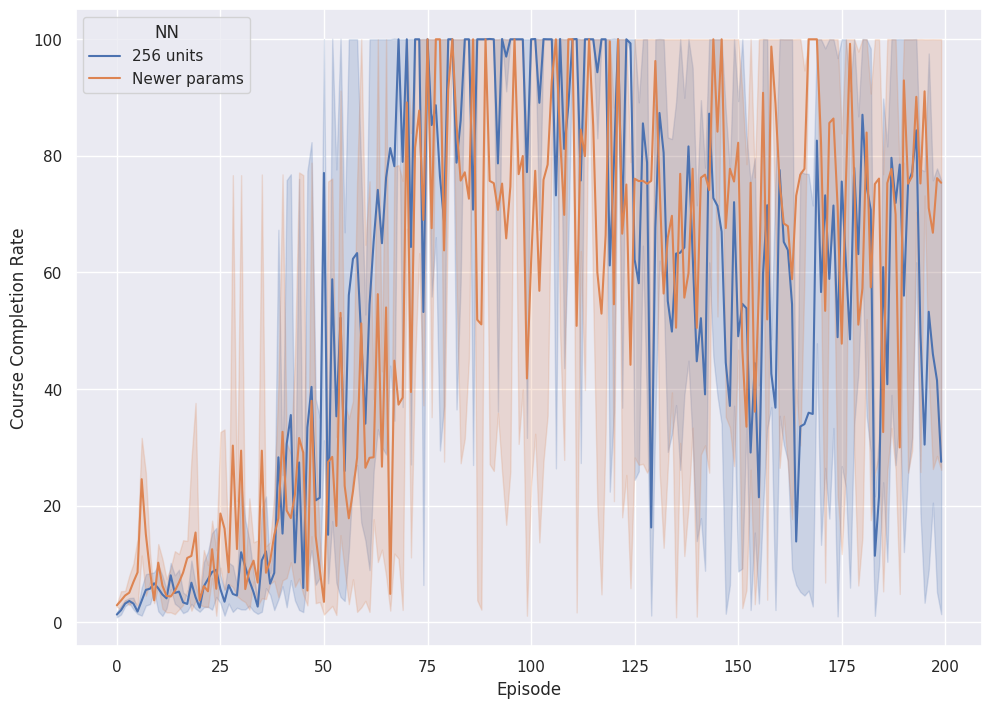

In [118]:
df_nn = pd.concat([df_concat, df_concat_og])
sns.lineplot(df_nn, x='Episode', y='Course Completion Rate', hue='NN')

In [7]:
fig = p.get_figure()
fig.savefig("ppo-sample.pdf")

# Lane-follow Analysis

In [76]:
log_dir1 = "/mnt/persistent/lane-follow-ppo-my-reward/tmp_1/"
log_dir2 = "/mnt/persistent/lane-follow-ppo-my-reward/tmp_2/"
log_dir3 = "/mnt/persistent/lane-follow-ppo-my-reward/tmp_3/"
log_dir4 = "/mnt/persistent/lane-follow-ppo-my-reward/tmp_4/"
log_dir5 = "/mnt/persistent/lane-follow-ppo-my-reward/tmp_5/"
log_dir8 = "/mnt/persistent/lane-follow-ppo-my-reward/tmp_8/"

my_df1 = pd.read_csv(log_dir1 + "/monitor.csv", header=1).reset_index()
my_df2 = pd.read_csv(log_dir2 + "/monitor.csv", header=1).reset_index()
my_df3 = pd.read_csv(log_dir3 + "/monitor.csv", header=1).reset_index()
my_df4 = pd.read_csv(log_dir4 + "/monitor.csv", header=1).reset_index()
my_df5 = pd.read_csv(log_dir5 + "/monitor.csv", header=1).reset_index()
my_df8 = pd.read_csv(log_dir8 + "/monitor.csv", header=1).reset_index()
ppo_df = pd.concat([
    my_df1,
    my_df2,
    my_df3,
    my_df4,
    my_df5,
    my_df8,
])
ppo_df["Algorithm"] = "PPO"

In [77]:
log_dir1 = "/mnt/persistent/lane-follow-sac/tmp_1/"
log_dir2 = "/mnt/persistent/lane-follow-sac/tmp_2/"
log_dir3 = "/mnt/persistent/lane-follow-sac/tmp_3/"
log_dir4 = "/mnt/persistent/lane-follow-sac/tmp_4/"
log_dir5 = "/mnt/persistent/lane-follow-sac/tmp_5/"
log_dir8 = "/mnt/persistent/lane-follow-sac/tmp_47/"

my_df1 = pd.read_csv(log_dir1 + "/monitor.csv", header=1).reset_index()
my_df2 = pd.read_csv(log_dir2 + "/monitor.csv", header=1).reset_index()
my_df3 = pd.read_csv(log_dir3 + "/monitor.csv", header=1).reset_index()
my_df4 = pd.read_csv(log_dir4 + "/monitor.csv", header=1).reset_index()
my_df5 = pd.read_csv(log_dir5 + "/monitor.csv", header=1).reset_index()
my_df8 = pd.read_csv(log_dir8 + "/monitor.csv", header=1).reset_index()
sac_df = pd.concat([
    my_df1,
    my_df2,
    my_df3,
    my_df4,
    my_df5,
    my_df8,
])
sac_df["Algorithm"] = "SAC"

In [78]:
log_dir1 = "/mnt/persistent/lane-follow-a2c/tmp_1/"
log_dir2 = "/mnt/persistent/lane-follow-a2c/tmp_2/"
log_dir3 = "/mnt/persistent/lane-follow-a2c/tmp_3/"
log_dir4 = "/mnt/persistent/lane-follow-a2c/tmp_4/"
log_dir5 = "/mnt/persistent/lane-follow-a2c/tmp_5/"
log_dir8 = "/mnt/persistent/lane-follow-a2c/tmp_47/"

my_df1 = pd.read_csv(log_dir1 + "/monitor.csv", header=1).reset_index()
my_df2 = pd.read_csv(log_dir2 + "/monitor.csv", header=1).reset_index()
my_df3 = pd.read_csv(log_dir3 + "/monitor.csv", header=1).reset_index()
my_df4 = pd.read_csv(log_dir4 + "/monitor.csv", header=1).reset_index()
my_df5 = pd.read_csv(log_dir5 + "/monitor.csv", header=1).reset_index()
my_df8 = pd.read_csv(log_dir8 + "/monitor.csv", header=1).reset_index()
a2c_df = pd.concat([
    my_df1,
    my_df2,
    my_df3,
    my_df4,
    my_df5,
    my_df8,
])
a2c_df["Algorithm"] = "A2C"

In [79]:
log_dir1 = "/mnt/persistent/lane-follow-td3/tmp_1/"
log_dir2 = "/mnt/persistent/lane-follow-td3/tmp_2/"
log_dir3 = "/mnt/persistent/lane-follow-td3/tmp_3/"
log_dir4 = "/mnt/persistent/lane-follow-td3/tmp_4/"
log_dir5 = "/mnt/persistent/lane-follow-td3/tmp_5/"
log_dir8 = "/mnt/persistent/lane-follow-td3/tmp_47/"

my_df1 = pd.read_csv(log_dir1 + "/monitor.csv", header=1).reset_index()
my_df2 = pd.read_csv(log_dir2 + "/monitor.csv", header=1).reset_index()
my_df3 = pd.read_csv(log_dir3 + "/monitor.csv", header=1).reset_index()
my_df4 = pd.read_csv(log_dir4 + "/monitor.csv", header=1).reset_index()
my_df5 = pd.read_csv(log_dir5 + "/monitor.csv", header=1).reset_index()
my_df8 = pd.read_csv(log_dir8 + "/monitor.csv", header=1).reset_index()
td3_df = pd.concat([
    my_df1,
    my_df2,
    my_df3,
    my_df4,
    my_df5,
    my_df8,
])
td3_df["Algorithm"] = "TD3"

In [80]:
log_dir1 = "/mnt/persistent/lane-follow-ddpg/tmp_1/"
log_dir2 = "/mnt/persistent/lane-follow-ddpg/tmp_2/"
log_dir3 = "/mnt/persistent/lane-follow-ddpg/tmp_3/"
log_dir4 = "/mnt/persistent/lane-follow-ddpg/tmp_4/"
log_dir5 = "/mnt/persistent/lane-follow-ddpg/tmp_5/"

my_df1 = pd.read_csv(log_dir1 + "/monitor.csv", header=1).reset_index()
my_df2 = pd.read_csv(log_dir2 + "/monitor.csv", header=1).reset_index()
my_df3 = pd.read_csv(log_dir3 + "/monitor.csv", header=1).reset_index()
my_df4 = pd.read_csv(log_dir4 + "/monitor.csv", header=1).reset_index()
my_df5 = pd.read_csv(log_dir5 + "/monitor.csv", header=1).reset_index()
ddpg_df = pd.concat([
    my_df1,
    my_df2,
    my_df3,
    my_df4,
    my_df5,
])
ddpg_df["Algorithm"] = "DDPG"

In [82]:
lane_follow_df = pd.concat([
    ppo_df,
    sac_df,
    a2c_df,
    td3_df,
    ddpg_df
])
lane_follow_df = lane_follow_df.rename(columns={'index': 'Episode', 'course_completion_rate': 'Course Completion Rate'})

,index,r,l,t,out_of_lane,exceed_max_rot,agent_done,course_completion_rate,Algorithm
0,0,67.002060,51,13.830083,False,True,False,3.3575,PPO
1,1,84.198685,77,17.553295,False,True,False,2.1195,PPO
2,2,135.900730,115,22.738863,False,True,False,3.2867,PPO
3,3,180.001900,128,24.773325,False,True,False,8.0859,PPO
4,4,211.570480,208,35.491061,False,True,False,6.4596,PPO
...,...,...,...,...,...,...,...,...,...
200,200,0.000000,1,44.409938,False,True,False,0.0481,DDPG
201,201,0.000000,1,44.410001,False,True,False,0.1938,DDPG
202,202,0.000000,1,44.410046,False,True,False,0.0447,DDPG
203,203,0.000000,1,44.410099,False,True,False,0.0608,DDPG
